In [330]:
from IPython.display import Image, IFrame

# ignore warnings so they don't bleed into the slides.
import warnings
warnings.filterwarnings('ignore')

image_defaults = {'height': 800, 'width': 600}

%matplotlib notebook

# Analyzing the ElectroCardioGram (ECG) and classifying what's healthy and what's not.
<small>-- Emlyn Clay, PhD</small>

# Emlyn Clay

I read Pharmacology for my Bachelors' and Doctorate and for a time I worked as a preclinical in vivo pharmacologist studying the the cardiotoxicological effects of a novel PDE<sub>i</sub>, RPL554, while working for Verona Pharma plc.

During that time, I worked under Professor Michael Walker and together we attempted various automated approaches to analysing the ECG and looking at the effect that RPL554 had on the QT interval, a biomarker for increased cardiac liability to arrthymia. 

In 2009, I established OpenVivo ltd; a biomedical and medical distribution company that focused on providing open access to the data that was recorded in such experiments and I continue to run that today. 

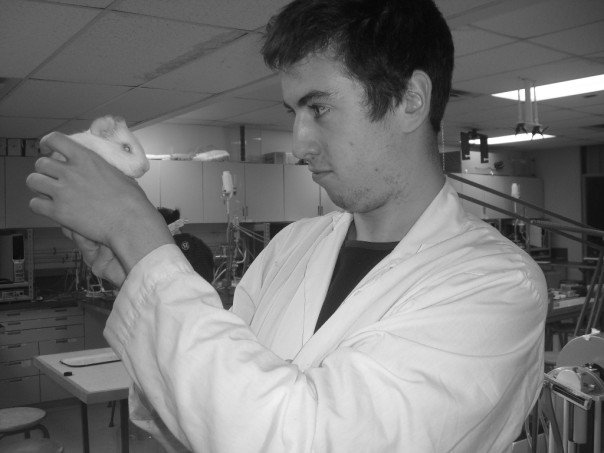

In [306]:
Image('images/emlyn_looking_at_guinea_pig.jpg')

# The ECG

The ECG is the electrical signal emitted by the muscles of the heart as it goes through a three phase sequence of events.

+ Depolarisation and contraction of the atria, (P wave).
+ Depolarisation and contraction of the ventricles (QRS complex).
+ Repolaristion of the heart (T wave).

The electrical signal is generated by the movement of ions through specialised channels in the cell walls of the myocytes (muscle cells) in the heart. The dominant ions involved are sodium (Na<sup>+</sup>), potassium (K<sup>+</sup>) and chloride (Cl<sup>-</sup>).

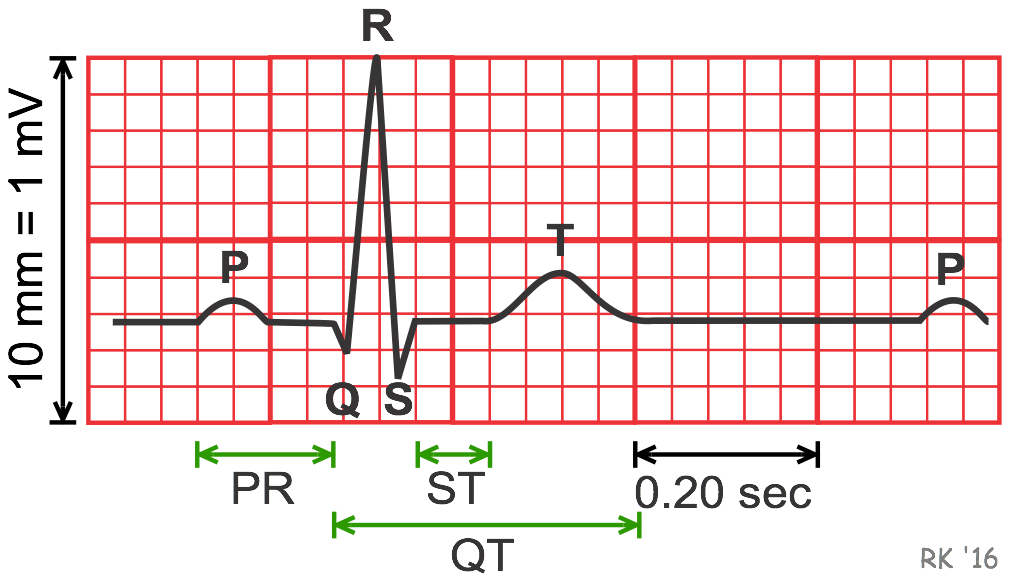

In [307]:
Image("images/ecg.png", **image_defaults)

# Normal ECG

A normal human ECG beats between 50 to 80 times a minutes at rest, at between 120 to 150 during exercise. A good sign of cardiovascular fitness is a low resting heart rate and a low maximum heart rate under exercise. 

The reasoning is fairly simple; a higher rate indicates that the heart is having to work harder to maintain normal saturation of your tissues. Some factors that determine your resting heart rate are the 

+ Size of your heart.
+ Peripheral blood pressure.
+ Weight.
+ Vasotone of your vascular beds, kidneys predominately.
+ Genetic blood disorders such as sickle cell anaemia.

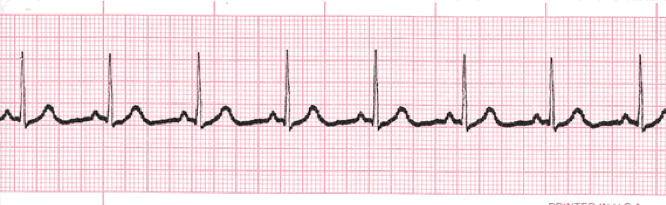

In [308]:
Image("images/ecg_normal_sinus_rhythm.png", **image_defaults)

# Recording the ECG

I recorded my ECG at rest on Lead II of the standard ECG, this produces the characteristic shape that we expect from the ECG. I used a g.USBamp (g.tec medical engineering, GmBH) and their recording software to aquire the data in an HDF5 format. Recorded at 1.2kHz for 10 minutes, no high-pass filter, 100Hz low-pass filter.

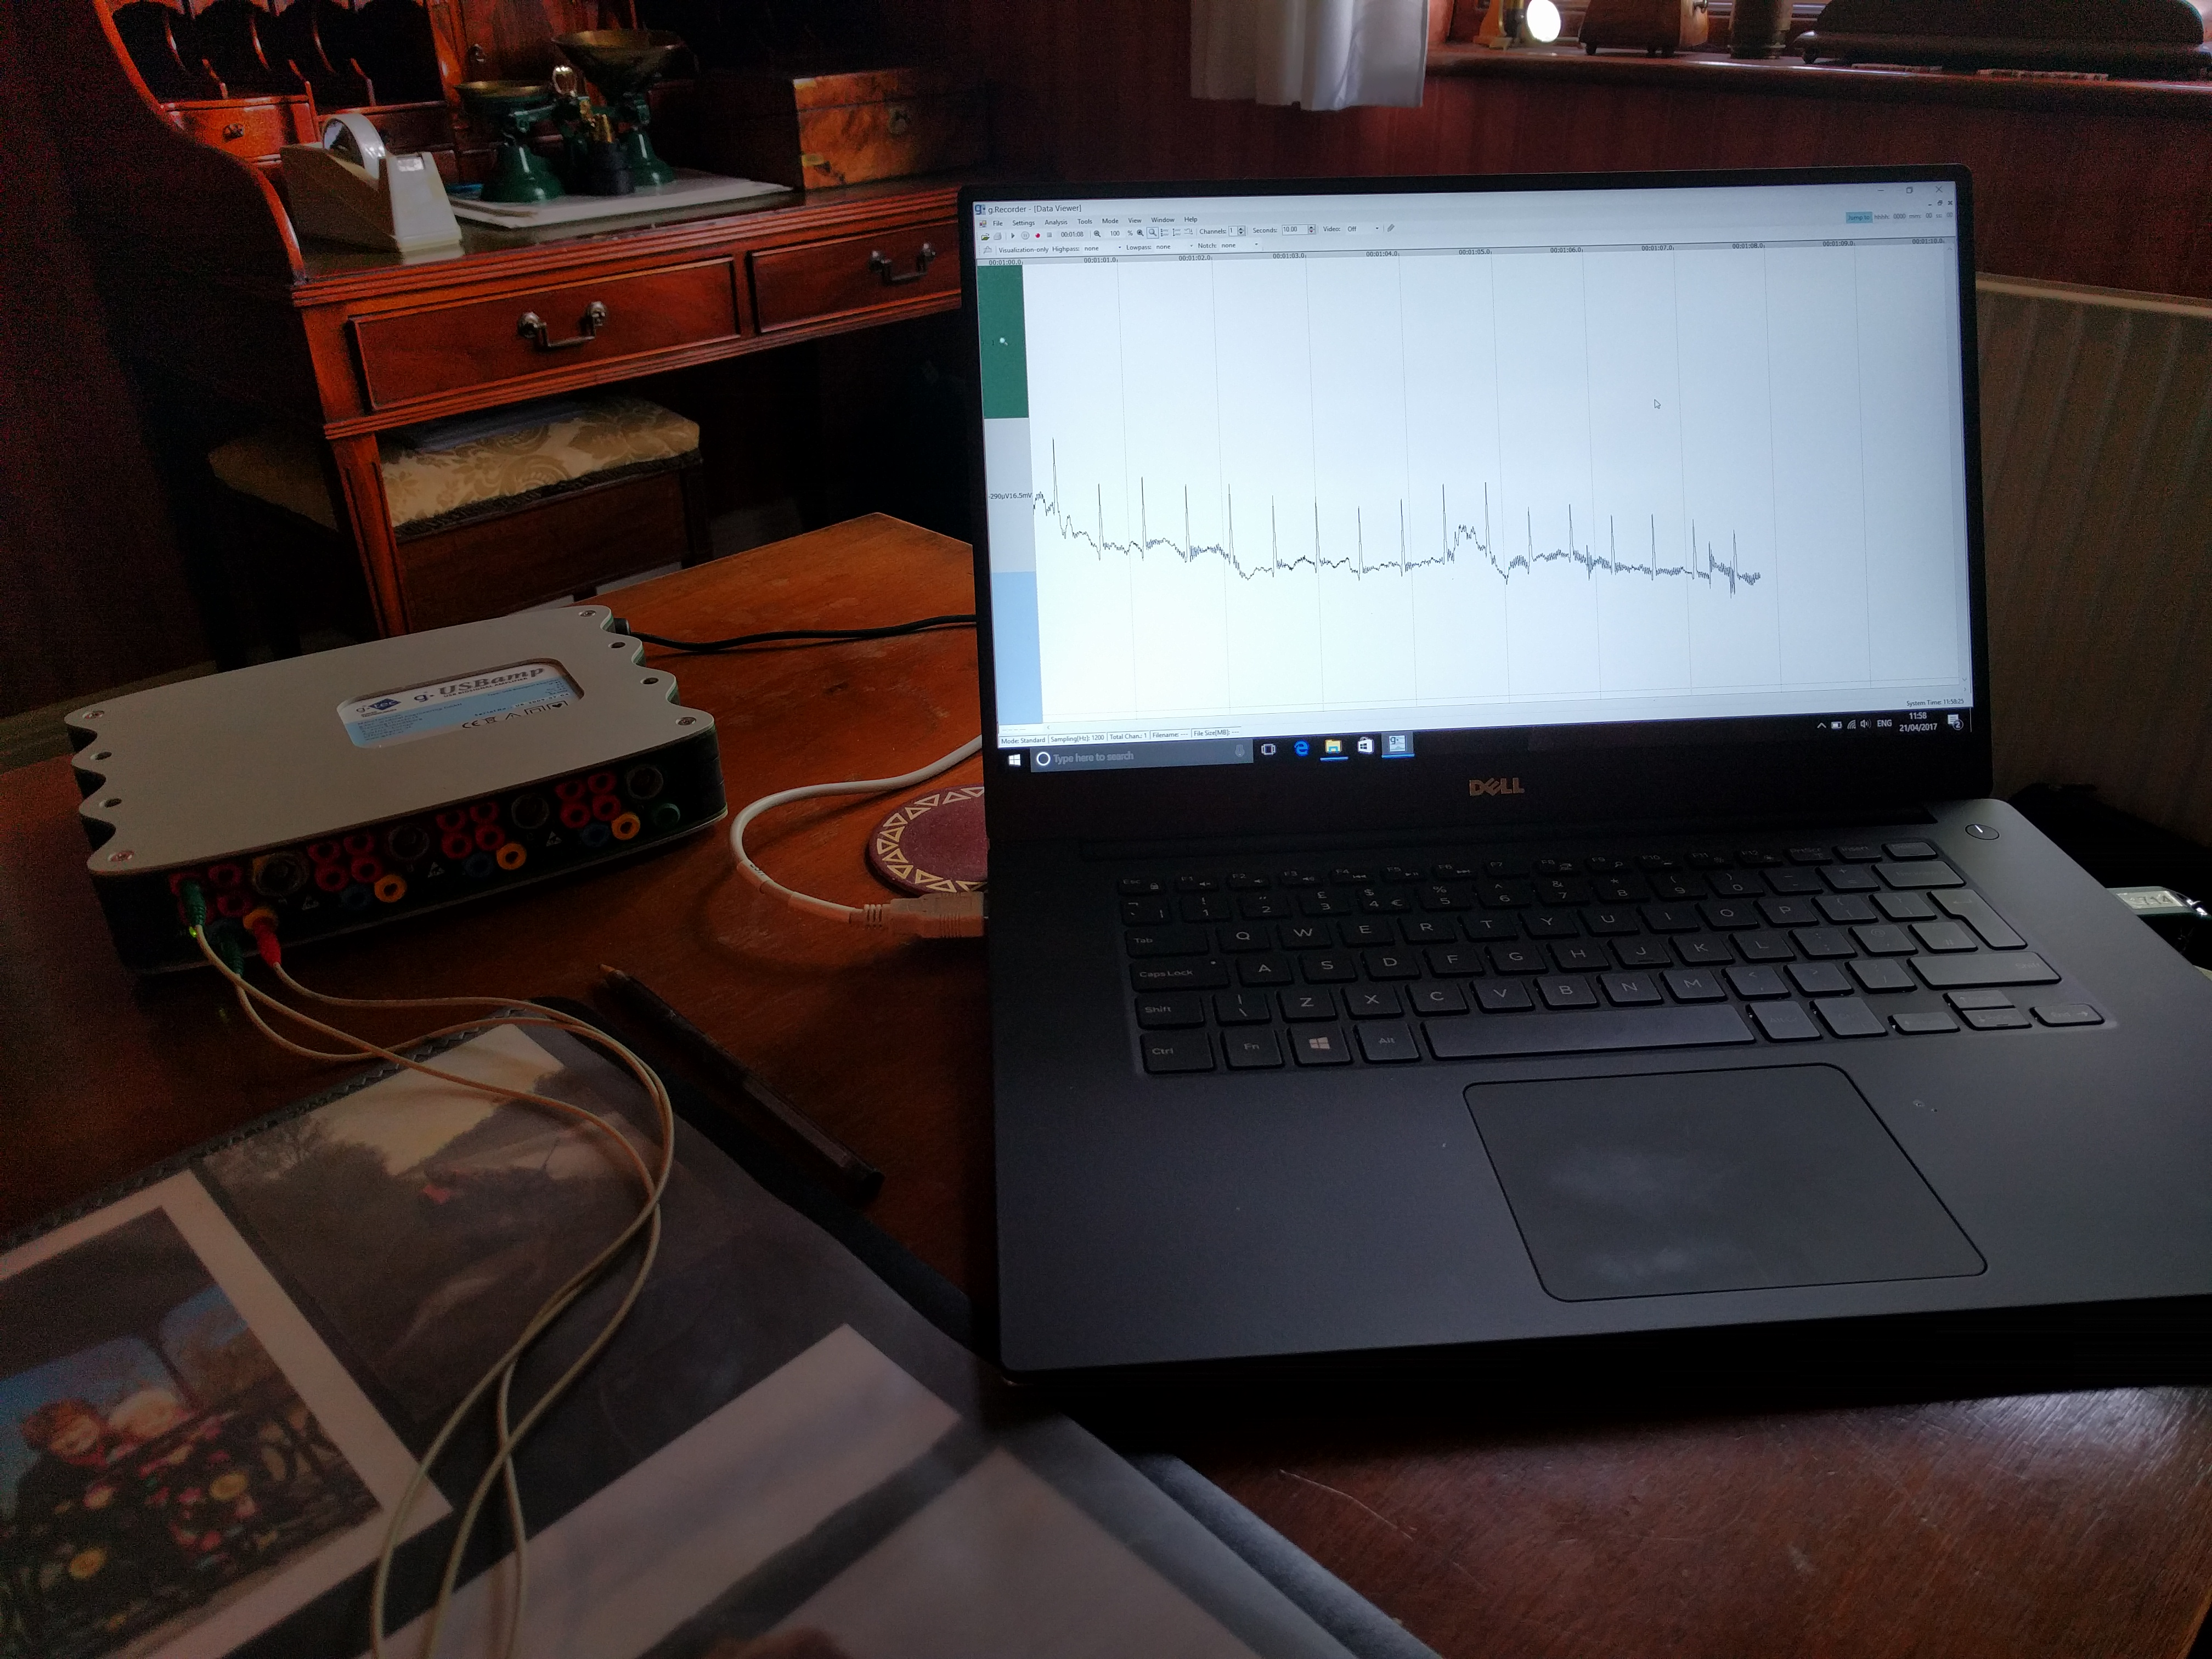

In [309]:
Image("images/emlyn_recording_his_ecg.jpg", **image_defaults)

This is how the first ECG was recorded in 1903

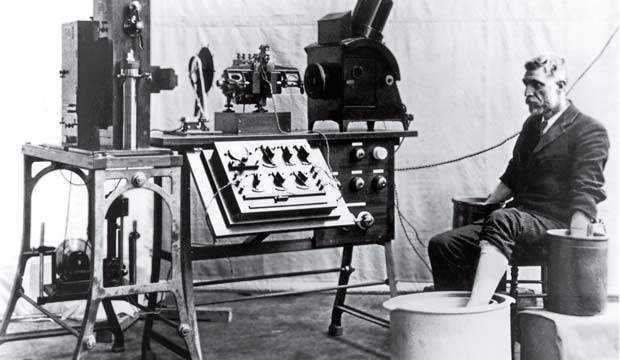

In [310]:
Image("images/willem_einthoven.jpg")

# Electrode placement

Lead II tends to give you to characteristic shape of the ECG.

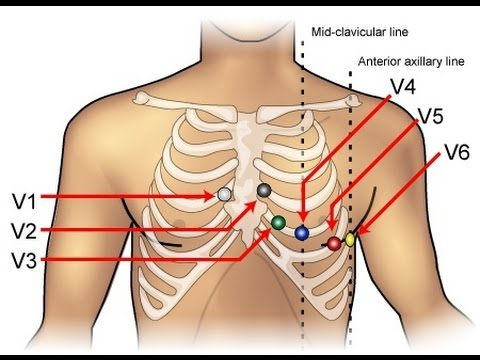

In [311]:
Image('images/ecg_lead_placement.jpg')

# Libraries I'm going to use

In [312]:
import h5py # for loading data

import numpy as np # contiguous C arrays
import pandas as pd # for the dataframe object mostly

import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for pretty graphs

import scipy.signal as signal # for general signal processing
import peakutils # for basic peak finding utils
import pywt # for wavelet transform bits

import wfdb # for physionet tools

# Load the data

In [332]:
h5file = h5py.File("data/emlyn_ECG_sitting_2017.04.21_11.48.30.hdf5", 'r')
dataset = h5file['RawData/Samples']
ecg_data = np.zeros((dataset.shape[0],1), dtype='d')
dataset.read_direct(ecg_data, np.s_[:], np.s_[:])

ecg_data = pd.DataFrame(data=ecg_data[500:], columns=['lead_II']) # sample 0:500, mucked

<IPython.core.display.Javascript object>


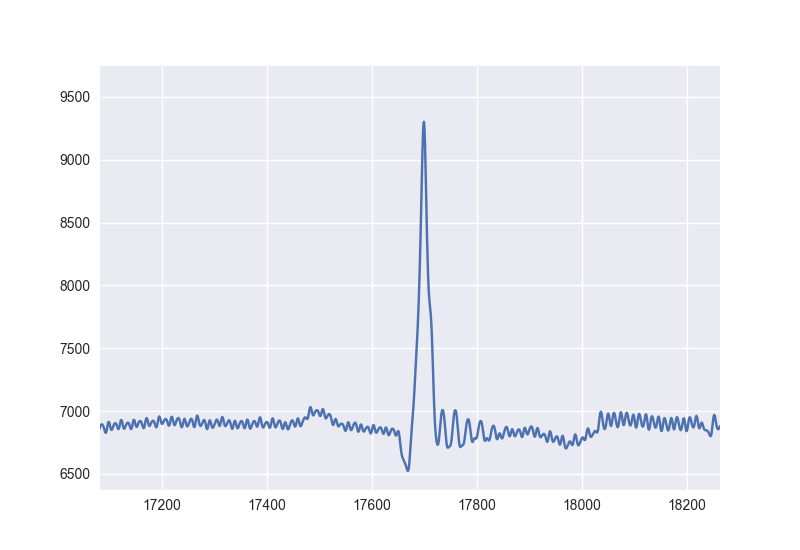

In [333]:
fig, ax = plt.subplots()
ax.plot(ecg_data['lead_II'])

# Preprocessing signal

Signals are often noisy, the main sources of this noise:

+ Activity of other body muscles, 
+ Baseline shift because of respiration
+ Poor contact of electrodes, and equipment or electronic devices
+ Inducted electrical noise

... thus we need often need to **detrend** and **filter** the noisy signal. 

In [315]:
data = ecg_data['lead_II'][0:2000]

# Detrend and filter - butterworth

Detrending is usually a case of removing any large baseline shifts, these are often be movement artifacts and tend to be low frequency components. Other noise, tends to be higher frequency and this can be removed by removing frequencies above what we are interested in.

Butterworth filters are traditionally used as the filter kernel, but the state of the art to denoise a signal are wavelet transformations

<IPython.core.display.Javascript object>


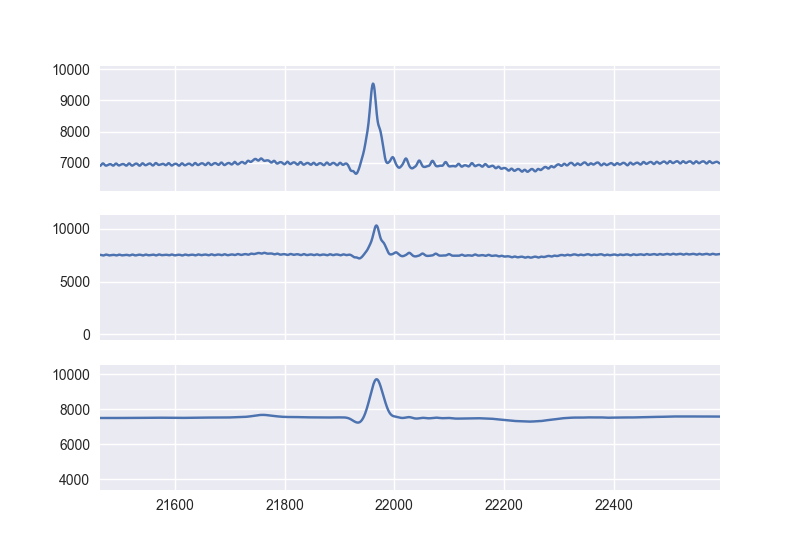

In [334]:
fig, ax = plt.subplots(3, sharex=True)

# apply a butterworth filter
lowpass = 100
highpass = 0.01

a, b = signal.butter(6, (highpass, lowpass), btype='bandpass', analog=True)
filtered_signal = signal.lfilter(b, a, ecg_data['lead_II'])
smoothed_signal = signal.cspline1d(filtered_signal, lamb=1000)

ax[0].plot(ecg_data['lead_II'])
ax[1].plot(filtered_signal)
ax[2].plot(smoothed_signal)

# Detrend and filter - wavelets

Wavelets are functions that you can use to decompose signals. A Fourier transform decomposes a signal into a family of complex sinusoids, whereas a wavelet transform decomposes a signal into a family of wavelets. 

Unlike sinusoids, which are symmetric, smooth, and regular, wavelets can be either symmetric or asymmetric, sharp or smooth, regular or irregular.

To use them, you decompose your signal into a series of wavelets 

<IPython.core.display.Javascript object>


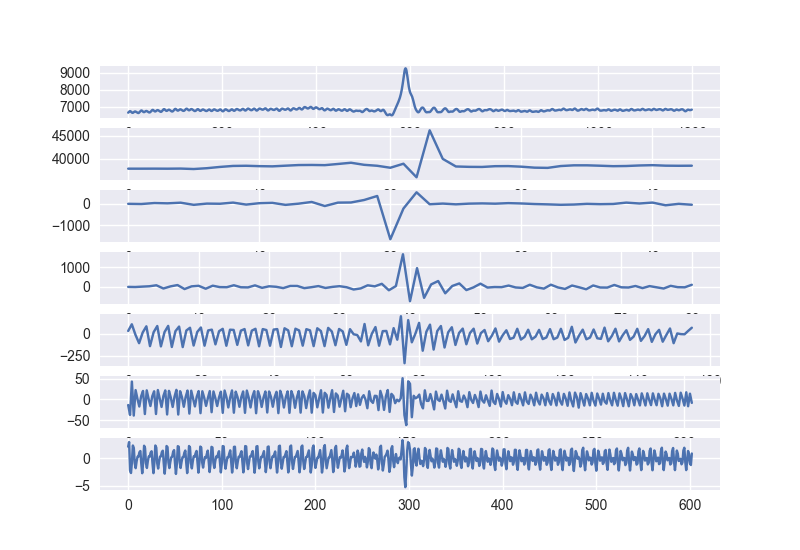

In [335]:
single_beat = ecg_data['lead_II'][1400:2600].values

wavelets = pywt.wavedec(single_beat,'db4', level=5)

fig, ax = plt.subplots(len(wavelets)+1)

ax[0].plot(single_beat)

for i, wavelet in enumerate(wavelets):
   ax[i+1].plot(wavelet)

In [343]:
fig, ax = plt.subplots()
ax.plot(pywt.waverec(wavelets[2:], 'db4'))

<IPython.core.display.Javascript object>

ValueError: coefficient shape mismatch

# We've got signal, preprocessed it ...

# ... now let's classify features from the ECG

# PhysioNet

We're now going to use the data from [PhysioNet](https://www.physionet.org), it is an enormous resource for all sorts of biological signals.

To get a list of the available datasets use `rsync` and we're going to use the [`python-wfdb`](https://github.com/MIT-LCP/wfdb-python) tool for the WaveForm DataBase (wfdb) tools.

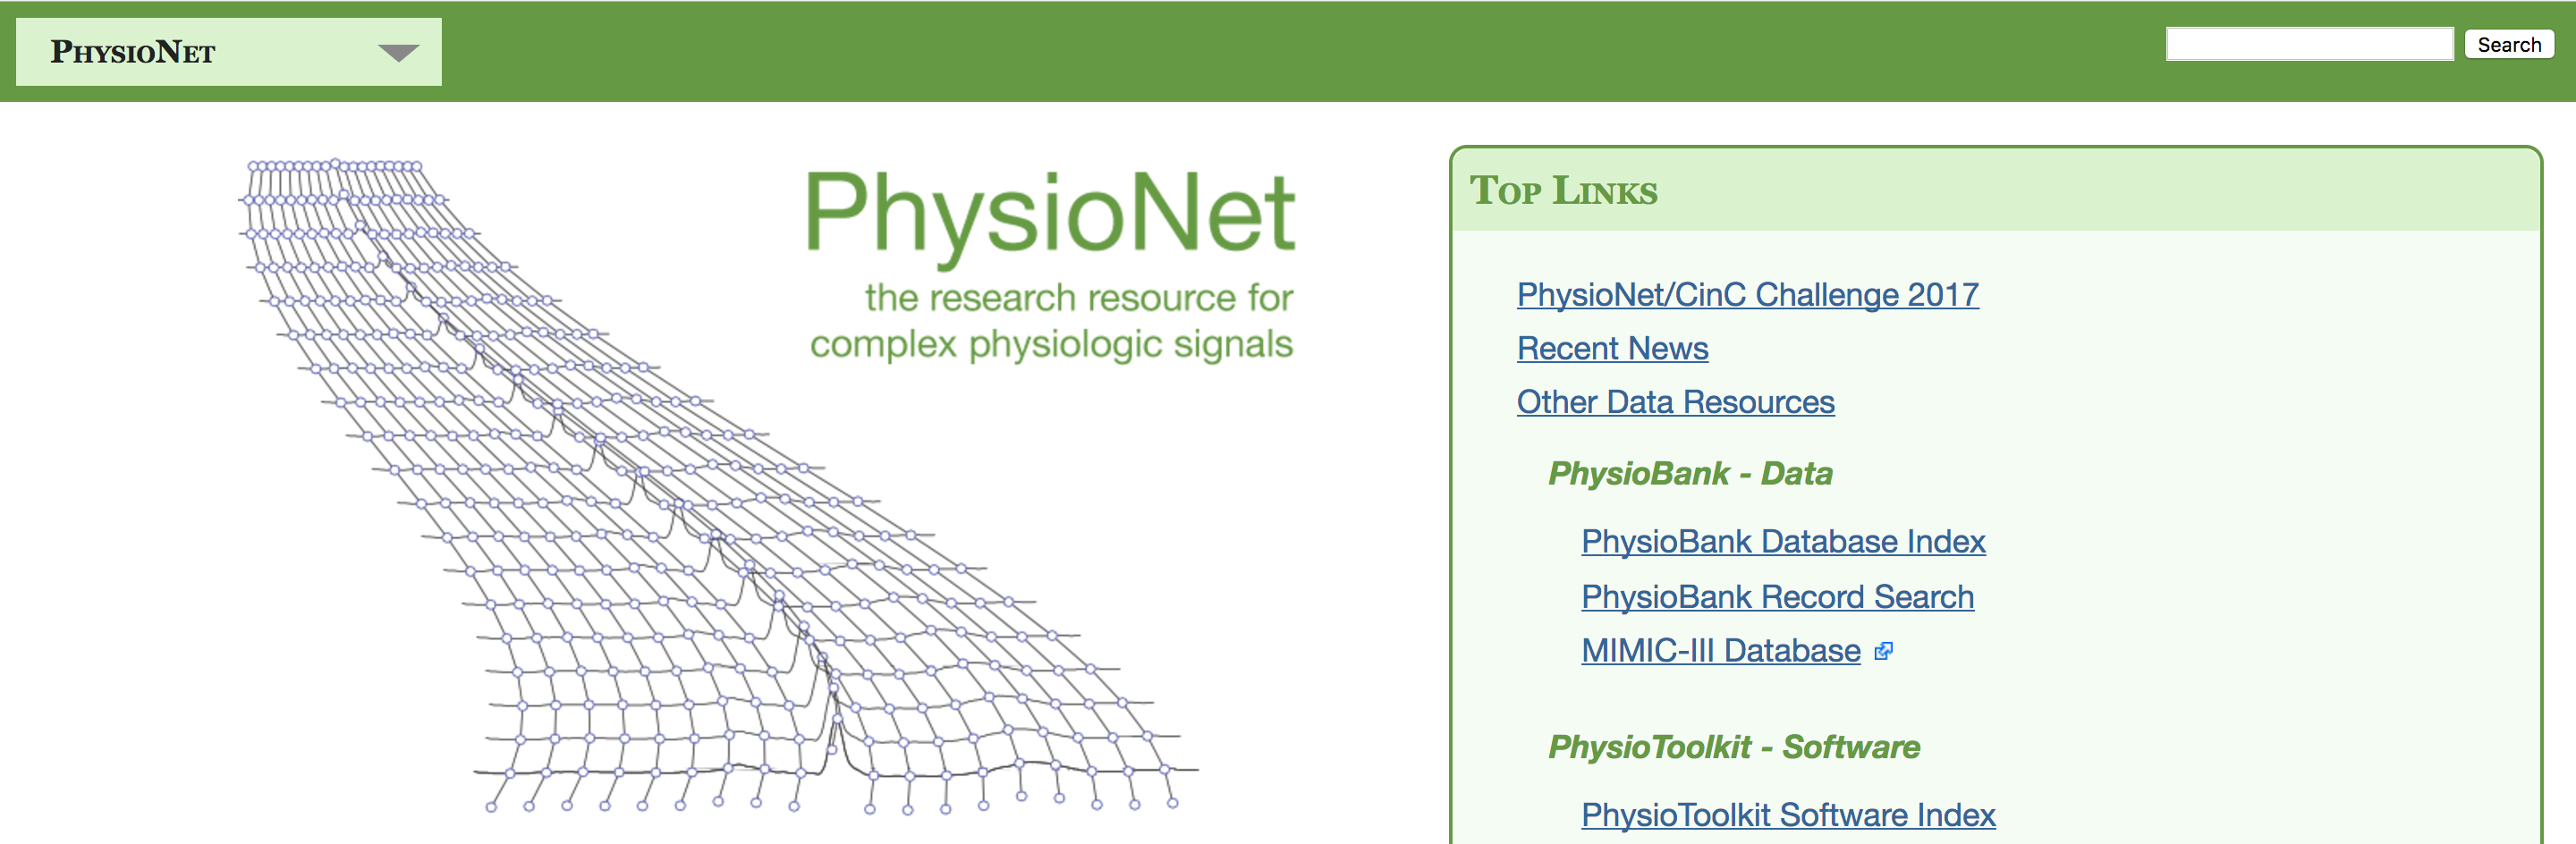

In [318]:
Image('images/physionet.png')

In [344]:
!rsync physionet.org::

rsync: failed to connect to physionet.org (128.30.30.88): Operation timed out (60)
rsync error: error in socket IO (code 10) at clientserver.c(125) [Receiver=3.1.2]


# qtdb, QT Database

> Over 100 fifteen-minute two-lead ECG recordings (many excerpted from other databases), with onset, peak, and end markers for P, QRS, T, and (where present) U waves of from 30 to 50 selected beats in each recording. A paper describing this database is available here.

><small>https://www.physionet.org/physiobank/database/qtdb/</small>

<IPython.core.display.Javascript object>


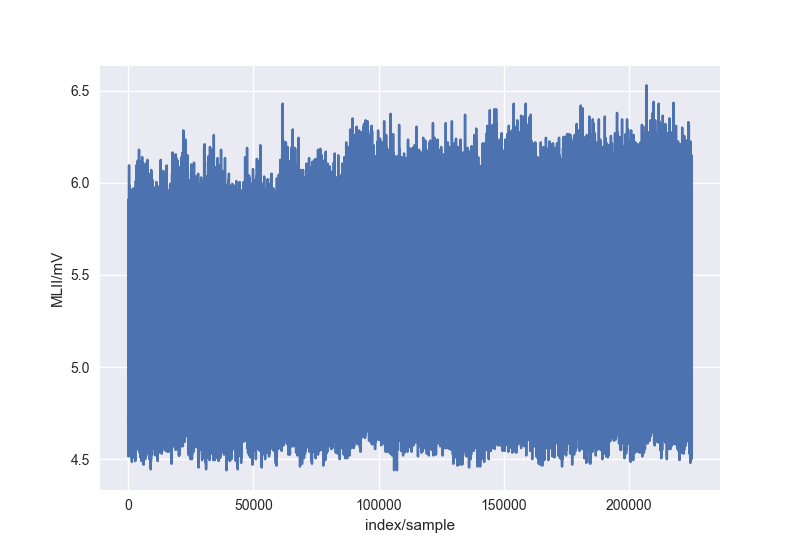

In [346]:
record = wfdb.rdsamp('data/wfdb/qtdb/sel100', channels=[0])
wfdb.plotrec(record)

In [345]:
record.__dict__

{'adcgain': [200.0],
 'adcres': [11],
 'adczero': [1024],
 'basecounter': None,
 'basedate': None,
 'baseline': [0],
 'basetime': None,
 'blocksize': [0],
 'byteoffset': [None],
 'checksum': [-13873],
 'comments': ['69 M 1085 1629 x1',
  'Aldomet, Inderal',
  'Produced by xform from record 100, beginning at 7:00.000'],
 'counterfreq': 360.0,
 'd_signals': None,
 'filename': ['sel100.dat'],
 'fmt': ['212'],
 'fs': 250.0,
 'initvalue': [945],
 'nsig': 1,
 'p_signals': array([[ 4.725],
        [ 4.735],
        [ 4.725],
        ..., 
        [ 4.695],
        [ 4.68 ],
        [ 4.68 ]]),
 'recordname': 'sel100',
 'sampsperframe': [None],
 'siglen': 225000,
 'signame': ['MLII'],
 'skew': [None],
 'units': ['mV']}

# Finding peaks

`peakutils` is somewhat similar to the `findpeaks` function in the Signal Processing Toolbox in MATLAB. It's simple to use and great for prototyping and exploring.

<IPython.core.display.Javascript object>


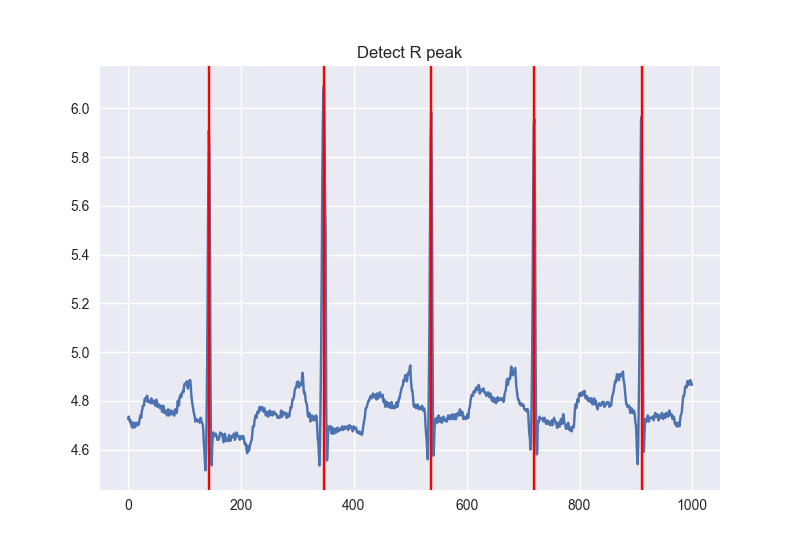

In [347]:
signal_slice = np.ndarray.flatten(record.p_signals[0:1000])

peak_index = peakutils.indexes(data_slice, thres=0.3, min_dist=100)

fig, ax = plt.subplots()

ax.set_title('Detect R peak')
ax.plot(data_slice)

for peak in peak_index:
    ax.axvline(x=peak, color='r')

# _Smooth or interpolate_ then find peaks

Smoothing the signal before you run the peak finding algorithm, helps improve the accuracy of the classification because minor perturbations a removed. The absolute accuracy of the peak detection may go down, however, because we're classifying an smoothed or averaged signal and invariably information is lost. Thus, there is a compromise between how much you smooth the signal and loss of information.

Ideally, I would advise you classify the peaks on the smoothed signal and then project them onto the raw signal.

<IPython.core.display.Javascript object>


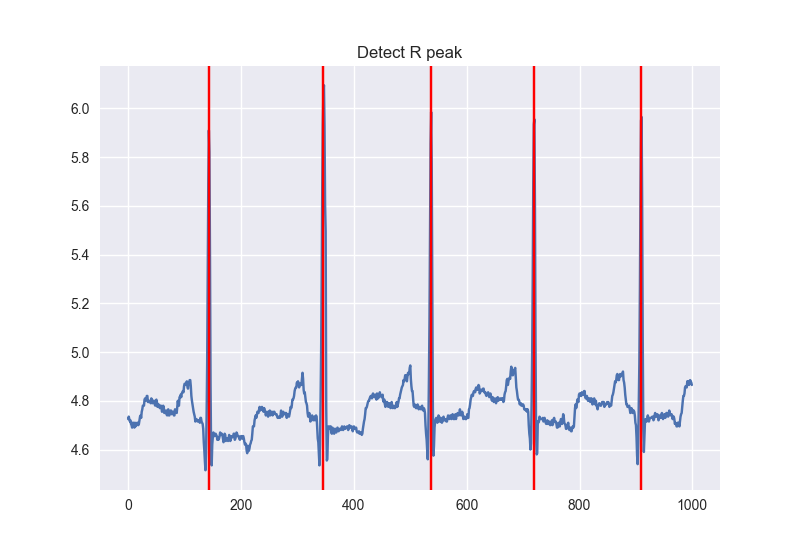

In [348]:
smoothed_signal = signal.cspline1d(signal_slice, lamb=1000)
r_peaks = peakutils.indexes(smoothed_signal, thres=0.5, min_dist=0.1)

fig, ax = plt.subplots()

ax.set_title('Detect R peak')
ax.plot(data_slice)

for peak in r_peaks:
    ax.axvline(x=peak, color='r')

# `signal.find_peaks_cwt` for noisy signals

`signal.find_peaks_cwt` is a very useful function that does a continuous wavelet transformation and then applies a peak fitting algorithm. The documentation neatly describes how works:


> The algorithm is as follows:
+ Perform a continuous wavelet transform on vector, for the supplied widths. This is a convolution of vector with wavelet(width) for each width in widths. See cwt
+ Identify “ridge lines” in the cwt matrix. These are relative maxima at each row, connected across adjacent rows. See identify_ridge_lines
+ Filter the ridge_lines using filter_ridge_lines.

> -- <cite>https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.find_peaks_cwt.html</cite>

<IPython.core.display.Javascript object>


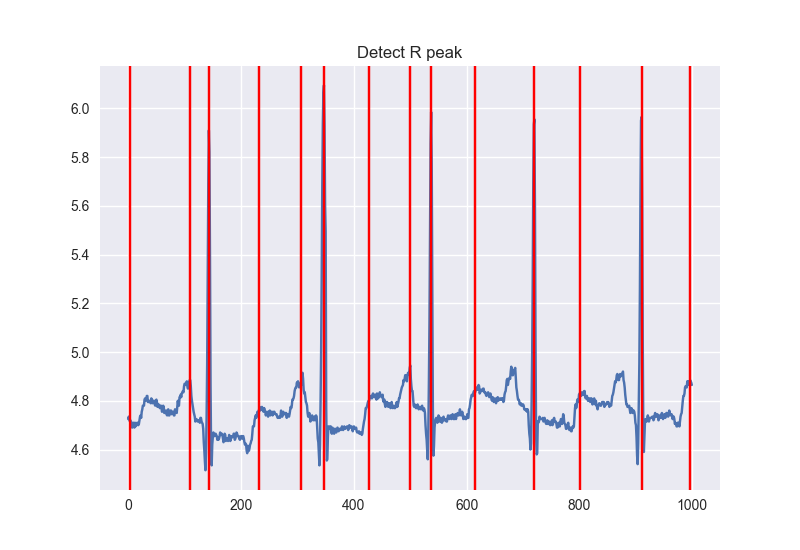

In [349]:
peaks = signal.find_peaks_cwt(signal_slice, widths=np.arange(1,80))

fig, ax = plt.subplots()

ax.set_title('Detect R peak')
ax.plot(data_slice)

for peak in peaks:
    ax.axvline(x=peak, color='r')

# Finding all the main ECG markers

It makes sense to classify the R peak first and then find the peaks around that main peak. R-peak detection rates are very high and thus reliable.

I haven't included the code to detect the peaks and then calculate information from them. That's an exercise for the reader, all the details earlier should inform you of how to do that. :-)

<IPython.core.display.Javascript object>


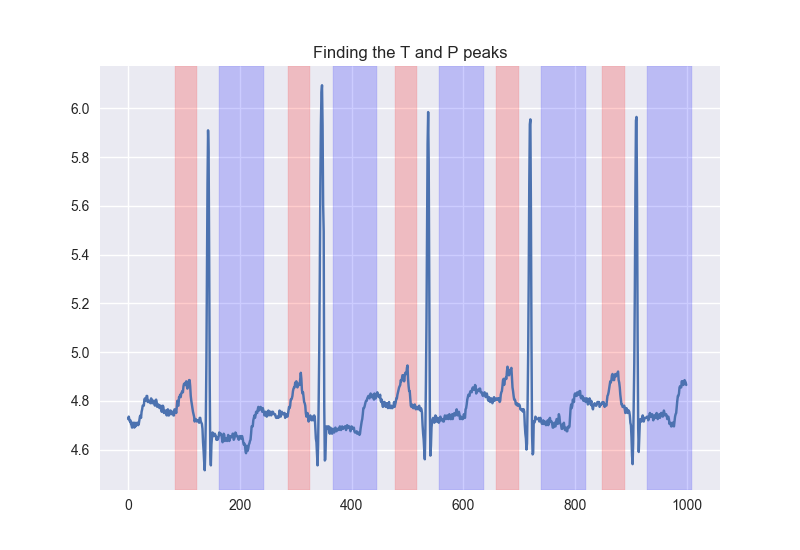

In [350]:
fig, ax = plt.subplots()

# finding the p_peaks
p_min_distance = -20
p_max_distance = -60

for peak in r_peaks:
    ax.axvspan(peak+p_max_distance, peak+p_min_distance, alpha=0.2, color='red')

# finding the t_peaks
t_min_distance = 20
t_max_distance = 100

for peak in r_peaks:
    ax.axvspan(peak+t_max_distance, peak+t_min_distance, alpha=0.2, color='blue')

ax.set_title('Finding the T and P peaks')
ax.plot(data_slice)

# We've got features, let's classify.

# A healthy state

+ Define it yourself in a control group
    - Consider, age, size, gender ...
    - At "rest", i.e. sitting.
+ Take normative values

# Heart rate (HR) and Heart Rate Variability (HRV)

A definitive resource for calculating HRV is the [Heart Rate Variability, 1996, Circulation](http://circ.ahajournals.org/content/93/5/1043#sec-2) publication.

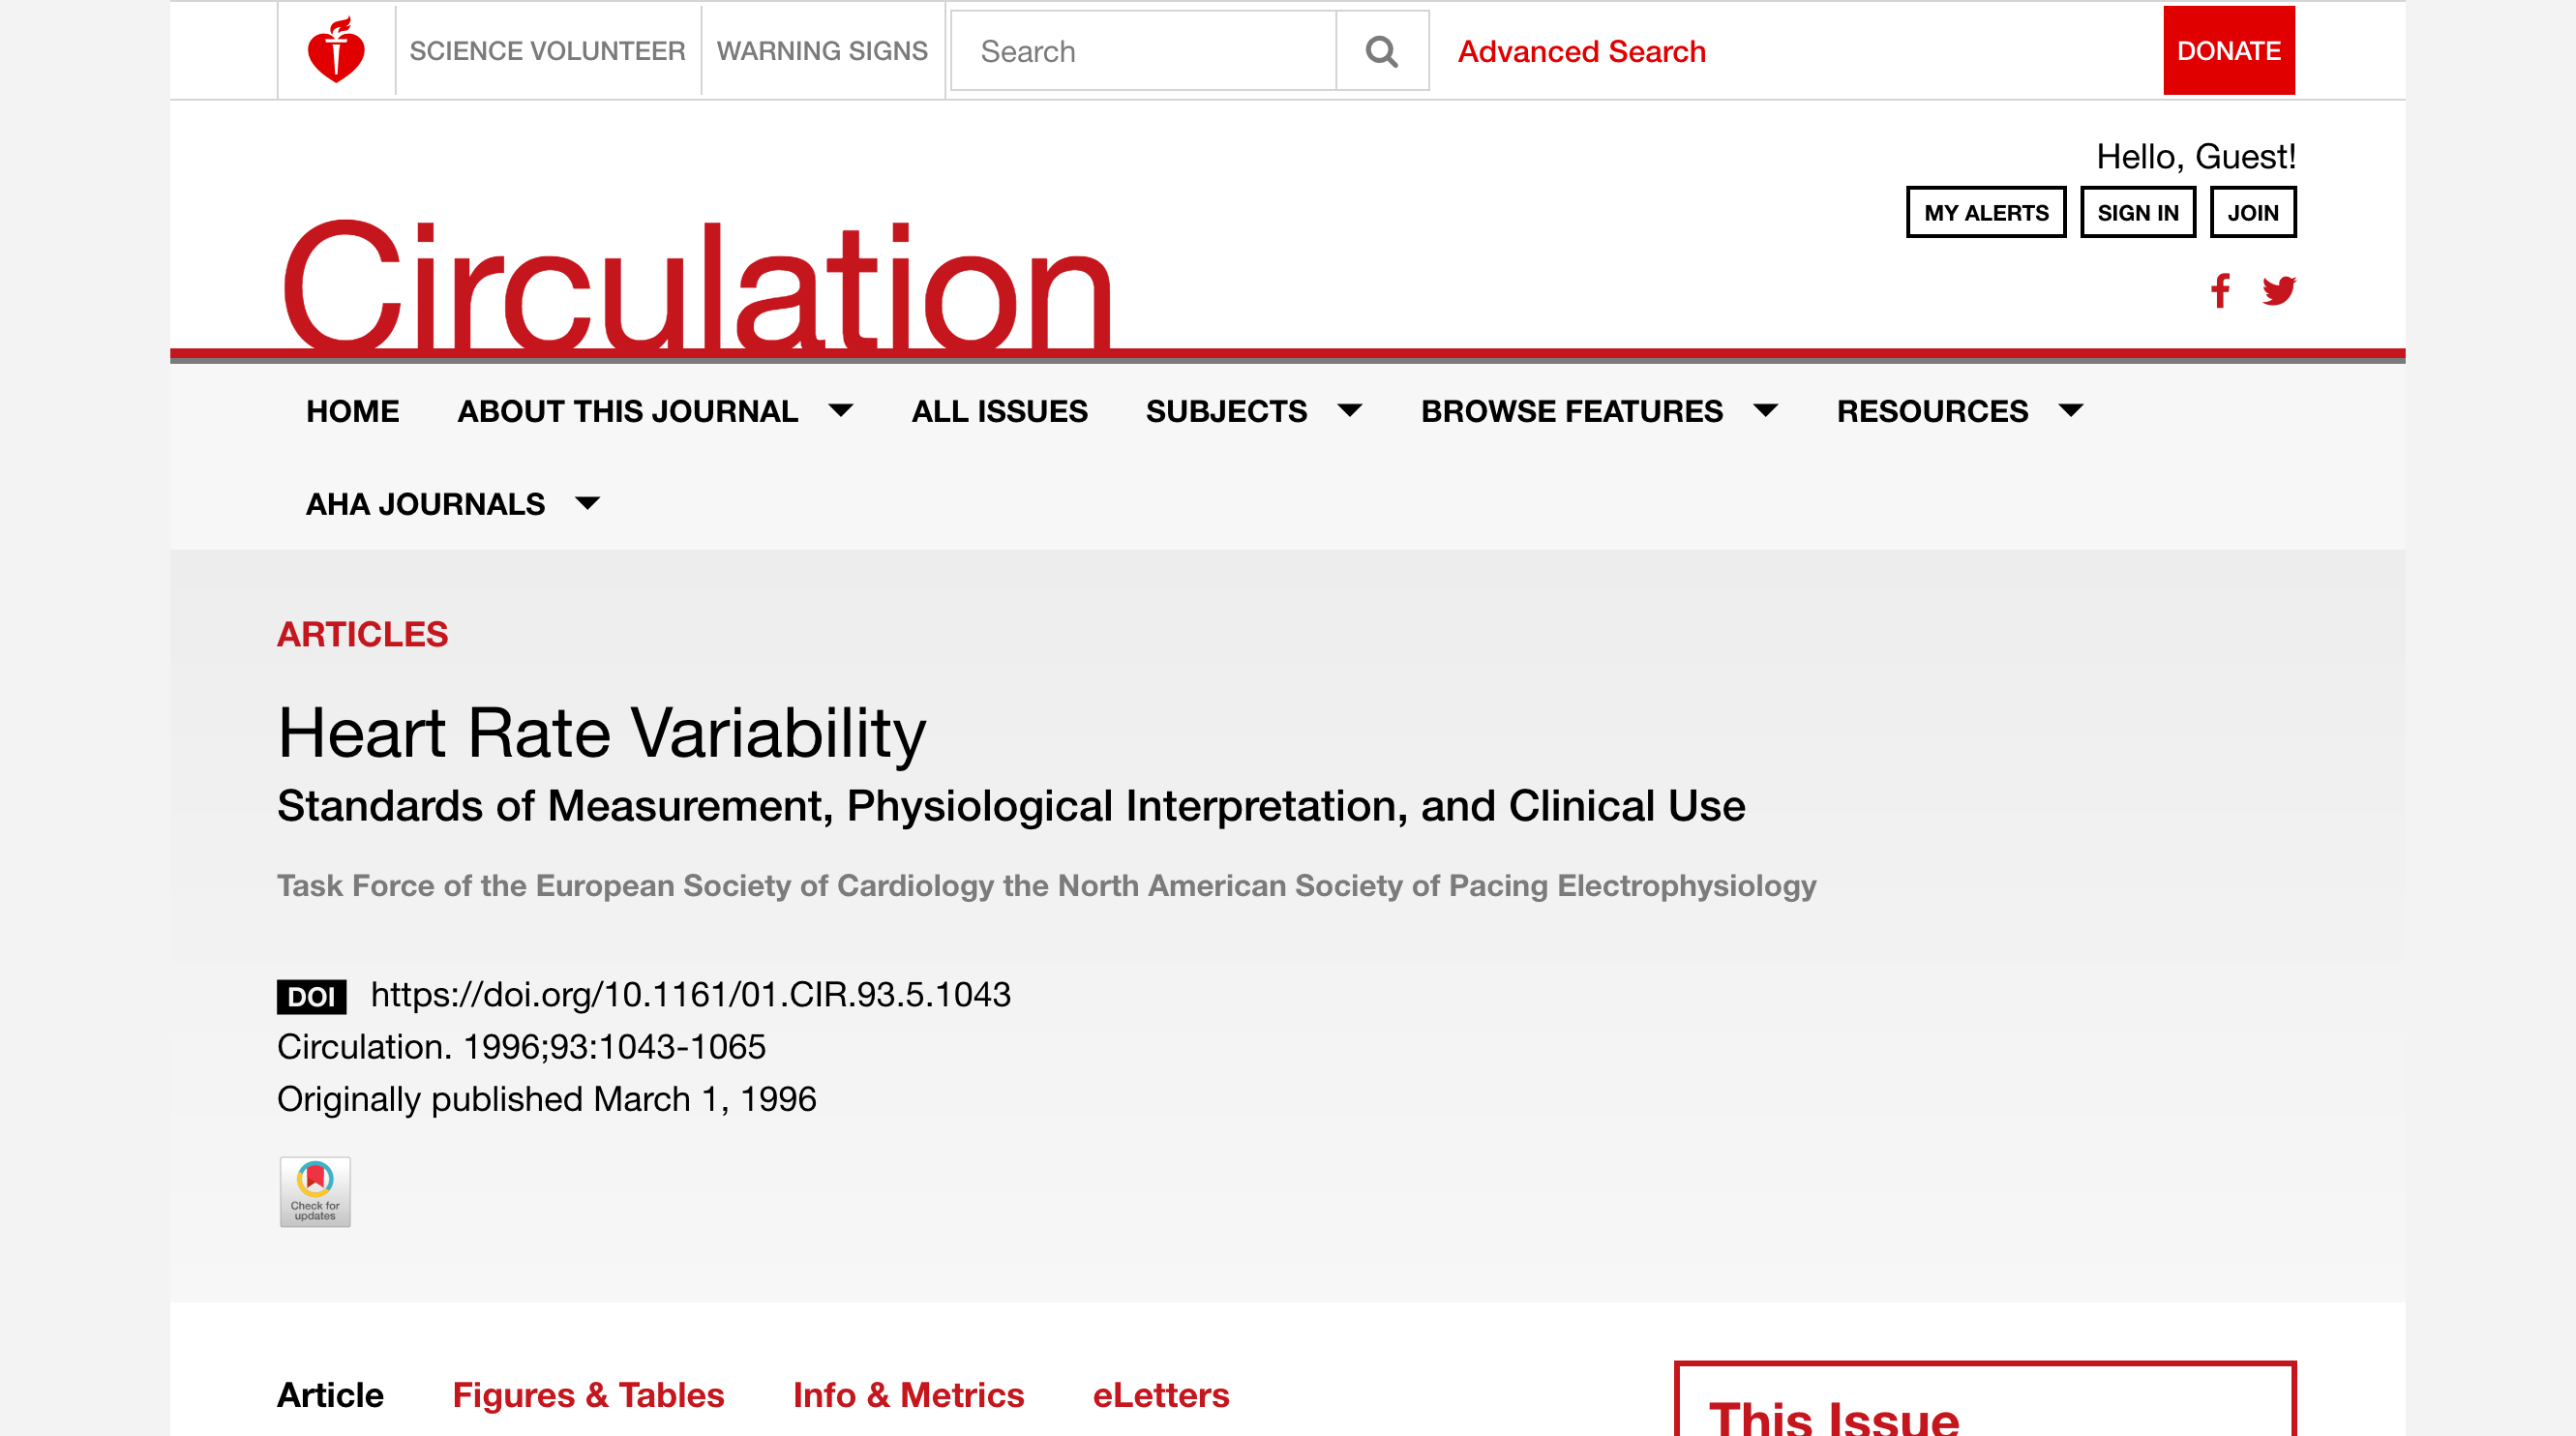

In [351]:
Image('images/circulation_article.png', **image_defaults)

# Calculate HR

<IPython.core.display.Javascript object>


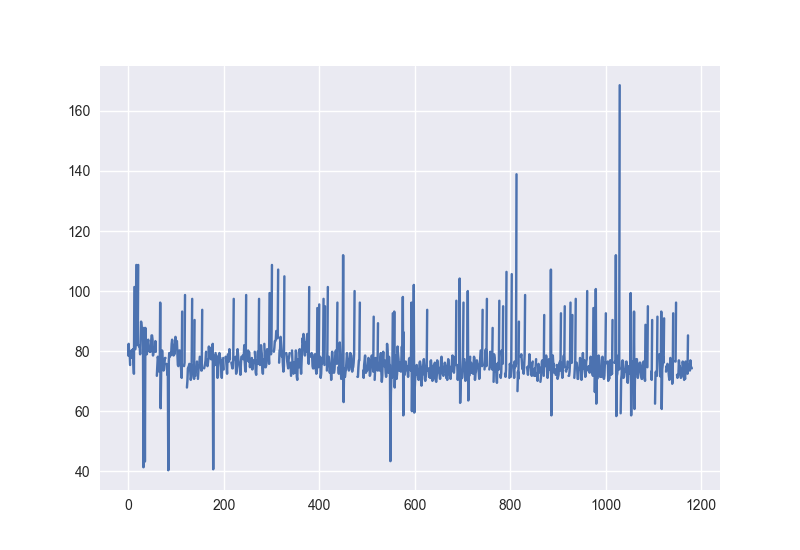

In [352]:
smoothed_signal = signal.cspline1d(np.ndarray.flatten(record.p_signals), lamb=1000)
r_peaks = peakutils.indexes(smoothed_signal, thres=0.5, min_dist=0.1)

# Convert the RR interval into heart rate
RR_intervals = np.diff(r_peaks) / record.fs
heart_rate = 60 / RR_intervals

# reject heart rates that are out of bounds
HR_max = 200
HR_min = 40

heart_rate = np.where((heart_rate < HR_max) & (heart_rate > HR_min), heart_rate, None)

fig, ax = plt.subplots()
ax.plot(heart_rate)

# Calculate HRV

In [353]:
# Summary statistics
df = pd.DataFrame(heart_rate, columns=["Heart rate"], dtype=float)
df.describe()

Heart rate
count  1059.000000
mean     77.662398
std       9.971782
min      40.322581
25%      73.170732
50%      75.757576
75%      78.534031
max     168.539326

# What can we infer from the HRV?

# Diseases

Reduced HRV —

+ Cardiomyopathy (Possible decrease in vagal tone)
+ Diabetic neuopathy (Alterations in nerve fibers)
+ Recent transplant (Alterations due to cardiac renervation)
+ Liver cirrhosis (Related to encephalopathy)

# Drug interactions

+ β-blockers
+ Anti-arrthymics

# Health indicators

+ Low heart rate and stable HRV is healthy
+ Exercise (Recovery of HR and HRV)
+ Stress (Increased LF components) 

# How is machine learning being used?

# To improve feature extraction from the ECG

[Machine Learning in Electrocardiogram Diagnosis, Salem et al, 2009](https://fedcsis.org/proceedings/2009/PTI/pliks/10.pdf)

In [327]:
IFrame(src='https://fedcsis.org/proceedings/2009/PTI/pliks/10.pdf', **image_defaults)

# To help diagnosis or suggest a diagnosis

[Learning to Diagnose with LSTM Recurrent Neural Networks, ZC Lipton, 2015](https://arxiv.org/pdf/1511.03677.pdf)

In [328]:
IFrame(src='https://arxiv.org/pdf/1511.03677.pdf', **image_defaults)

# Please come explain this to me!

In [ ]:
""" Inspired by example from
https://github.com/Vict0rSch/deep_learning/tree/master/keras/recurrent
Uses the TensorFlow backend
The basic idea is to detect anomalies in a time-series.
"""
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from savitzky_golay import savitzky_golay

np.random.seed(1234)

# Hyper-parameters
sequence_length = 50
random_data_dup = 10  # each sample randomly duplicated between 0 and 9 times, see dropin function
epochs = 1
batch_size = 50
path_to_dataset = 'mitdbx_mitdbx_108.txt'


def dropin(X, y):
    """ The name suggests the inverse of dropout, i.e. adding more samples. See Data Augmentation section at
    http://simaaron.github.io/Estimating-rainfall-from-weather-radar-readings-using-recurrent-neural-networks/
    :param X: Each row is a training sequence
    :param y: Tne target we train and will later predict
    :return: new augmented X, y
    """
    print(("X shape:", X.shape))
    print(("y shape:",y.shape))
    X_hat = []
    y_hat = []
    for i in range(0, len(X)):
        for j in range(0, np.random.random_integers(0,20)):
            X_hat.append(X[i, :])
            y_hat.append(y[i])
    return np.asarray(X_hat), np.asarray(y_hat)


def z_norm(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

def get_split_prep_data(train_start, train_end,
                          test_start, test_end):
    data = np.loadtxt(path_to_dataset)
    data = savitzky_golay(data[:, 1], 11, 3) # smoothed version
    print(("Length of Data", len(data)))

    # train data
    print("Creating train data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print("Mean of train data : ", result_mean)
    print("Train data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    np.random.shuffle(train)  # shuffles in-place
    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_train, y_train = dropin(X_train, y_train)

    # test data
    print("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print("Mean of test data : ", result_mean)
    print("Test data shape  : ", result.shape)

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print(("Shape X_train", np.shape(X_train)))
    print(("Shape X_test", np.shape(X_test)))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test


def build_model():
    model = Sequential()
    layers = {'input': 1, 'hidden1': 64, 'hidden2': 256, 'hidden3': 100, 'output': 1}

    model.add(LSTM(
            input_length=sequence_length - 1,
            input_dim=layers['input'],
            output_dim=layers['hidden1'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden2'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden3'],
            return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
            output_dim=layers['output']))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("Compilation Time : ", time.time() - start)
    return model


def run_network(model=None, data=None):
    global_start_time = time.time()
    epochs = 1

    if data is None:
        print('Loading data... ')
        X_train, y_train, X_test, y_test = get_split_prep_data(
                0, 3000, 3000, 12000)
    else:
        X_train, y_train, X_test, y_test = data

    print('\nData Loaded. Compiling...\n')

    if model is None:
        model = build_model()

    try:
        print("Training")
        model.fit(
                X_train, y_train,
                batch_size=512, nb_epoch=epochs, validation_split=0.05)
        print("Predicting")
        predicted = model.predict(X_test)
        print(("shape of predicted", np.shape(predicted), "size", predicted.size))
        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("prediction exception")
        print('Training duration (s) : ', time.time() - global_start_time)
        return model, y_test, 0

    try:
        plt.figure(1)
        plt.subplot(311)
        plt.title("Actual Signal w/Anomalies")
        plt.plot(y_test[:len(y_test)], 'b')
        plt.subplot(312)
        plt.title("Predicted Signal")
        plt.plot(predicted[:len(y_test)], 'g')
        plt.subplot(313)
        plt.title("Squared Error")
        mse = ((y_test - predicted) ** 2)
        plt.plot(mse, 'r')
        plt.show()
    except Exception as e:
        print("plotting exception")
        print(str(e))
    print('Training duration (s) : ', time.time() - global_start_time)

    return model, y_test, predicted

run_network()

# Want to be at the edge? Go to Computing in Cardiology

In [329]:
IFrame(src='http://www.cinc.org/', height="600", width=1024)

# Questions?

<br/>
### @emlynclay